In [1]:
# Imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get Project Files | LOAD
IMAGE_DIR = 'dataset'

FILE_LIST_TEMP = []

for dirname, _, filenames in os.walk(IMAGE_DIR):
    for filename in filenames:
        FILE_LIST_TEMP.append(os.path.join(dirname, filename))
        
# creating the finalized file list and label list
FILE_LIST = []
LABELS = []

for FILE_PATH in FILE_LIST_TEMP:
    label = FILE_PATH.split(os.path.sep)[-2]
    
    FILE_LIST.append(FILE_PATH)
    LABELS.append(label)


# Variables for pre-processing and training.
BATCH_SIZE = 32 # the higher the number, baka di na kayanin ng pc hahaha
epochs = 50 # number of times the model will be trained
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [3]:
df = pd.DataFrame(list(zip(FILE_LIST, LABELS)), columns = ['File path', 'Label'])
df

,File path,Label
0,dataset/ya/_3_5509983.png,ya
1,dataset/ya/_10_5506981.png,ya
2,dataset/ya/_9_3422722.png,ya
3,dataset/ya/_1_7534464.png,ya
4,dataset/ya/_2_6948069.png,ya
...,...,...
62995,dataset/la/_0_9429944.png,la
62996,dataset/la/_2_3522546.png,la
62997,dataset/la/_0_2781433.png,la
62998,dataset/la/_1_4777432.png,la


In [4]:
# shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,File path,Label
0,dataset/sa/_5_440146.png,sa
1,dataset/wu/_4_126206.png,wu
2,dataset/gu/_3_5392970.png,gu
3,dataset/yu/_3_1462945.png,yu
4,dataset/a/_0_9171424.png,a
...,...,...
62995,dataset/k/_4_1273399.png,k
62996,dataset/si/_3_3612564.png,si
62997,dataset/ni/_4_3503415.png,ni
62998,dataset/la/_2_1811414.png,la


In [5]:
# for splitting train and testing dataframe
from sklearn.model_selection import train_test_split

train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.25

train, test = train_test_split(df, test_size = test_ratio)
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

In [6]:
# PRE PROCESS
# creating an image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_datagen = ImageDataGenerator(rescale=1./255)

x_train = img_datagen.flow_from_dataframe(dataframe=train, x_col="File path", y_col="Label",
                                         target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse', color_mode='grayscale')

x_val = img_datagen.flow_from_dataframe(dataframe=val, x_col="File path", y_col="Label",
                                         target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse', color_mode='grayscale')

x_test = img_datagen.flow_from_dataframe(dataframe=test, x_col="File path", y_col="Label",
                                         target_size=(IMG_HEIGHT,IMG_WIDTH), shuffle=False, batch_size=BATCH_SIZE, class_mode='sparse', color_mode='grayscale')

Found 47250 validated image filenames belonging to 63 classes.
Found 4500 validated image filenames belonging to 63 classes.
Found 11250 validated image filenames belonging to 63 classes.


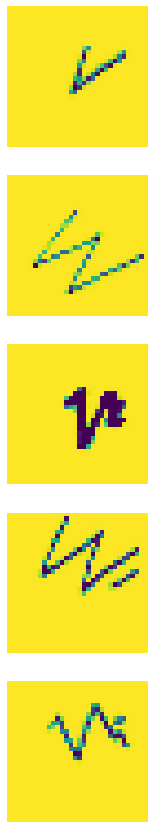

In [7]:
#PANG PLOT ITO
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

sample_training_images, _ = next(x_train)
plotImages(sample_training_images[:5])

In [8]:
def build_model(img_height, img_width, output_layer):
    # BUILD THE MODEL
    # CNN Architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 1))) # Input Layer
    # Subsequent Layes | Hidden Layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3)))

    #Dense layers | Pang-classify
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_layer))

    #Compile
    model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    model.summary()
    return model

In [9]:
# FIT THE DATA TO THE MODEL
save_dir = 'models'
saved_model = 'hanunuo_model'
OUTPUT_LAYERS = len(list(x_train.class_indices.keys()))
PATIENCE = 3

if saved_model not in os.listdir(save_dir):
    model = build_model(IMG_HEIGHT, IMG_WIDTH, OUTPUT_LAYERS)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=PATIENCE,
                                                mode='min')

    history = model.fit(x_train,
                       epochs=epochs,
                       validation_data=x_val,
                       callbacks=early_stopping)
    model.save(os.path.join(save_dir, saved_model))
    model.save(f'{os.path.join(save_dir, saved_model)}.h5')
else:
    model = tf.keras.models.load_model(os.path.join(save_dir, saved_model))
    model.summary()

2021-11-07 15:32:04.546312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 15:32:04.551912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 15:32:04.552326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 15:32:04.553131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

2021-11-07 15:32:05.668351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


1477/1477 [==============================] - 276s 184ms/step - loss: 2.0959 - accuracy: 0.4123 - val_loss: 0.9370 - val_accuracy: 0.7087
Epoch 2/50
1477/1477 [==============================] - 59s 40ms/step - loss: 0.7269 - accuracy: 0.7650 - val_loss: 0.6348 - val_accuracy: 0.7980
Epoch 3/50
1477/1477 [==============================] - 32s 22ms/step - loss: 0.4749 - accuracy: 0.8440 - val_loss: 0.4951 - val_accuracy: 0.8342
Epoch 4/50
1477/1477 [==============================] - 32s 22ms/step - loss: 0.3557 - accuracy: 0.8803 - val_loss: 0.4375 - val_accuracy: 0.8573
Epoch 5/50
1477/1477 [==============================] - 32s 22ms/step - loss: 0.2880 - accuracy: 0.9021 - val_loss: 0.4009 - val_accuracy: 0.8787
Epoch 6/50
1477/1477 [==============================] - 32s 22ms/step - loss: 0.2495 - accuracy: 0.9168 - val_loss: 0.2959 - val_accuracy: 0.9064
Epoch 7/50
1477/1477 [==============================] - 32s 22ms/step - loss: 0.2246 - accuracy: 0.9240 - val_loss: 0.3124 - val_accu

2021-11-07 15:41:25.587568: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/hanunuo_model/assets


In [10]:
test_accuracy = model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

352/352 [==============================] - 71s 202ms/step - loss: 0.3203 - accuracy: 0.9088
Test accuracy is :  90.88000059127808 %


In [11]:
# Show class index
print(x_train.class_indices)
baybayin_classes = list(x_train.class_indices.keys())

{'a': 0, 'b': 1, 'ba': 2, 'bi': 3, 'bu': 4, 'd': 5, 'da': 6, 'di': 7, 'du': 8, 'g': 9, 'ga': 10, 'gi': 11, 'gu': 12, 'h': 13, 'ha': 14, 'hi': 15, 'hu': 16, 'i': 17, 'k': 18, 'ka': 19, 'ki': 20, 'ku': 21, 'l': 22, 'la': 23, 'li': 24, 'lu': 25, 'm': 26, 'ma': 27, 'mi': 28, 'mu': 29, 'n': 30, 'na': 31, 'ng': 32, 'nga': 33, 'ngi': 34, 'ngu': 35, 'ni': 36, 'nu': 37, 'p': 38, 'pa': 39, 'pi': 40, 'pu': 41, 'r': 42, 'ra': 43, 'ri': 44, 'ru': 45, 's': 46, 'sa': 47, 'si': 48, 'su': 49, 't': 50, 'ta': 51, 'ti': 52, 'tu': 53, 'u': 54, 'w': 55, 'wa': 56, 'wi': 57, 'wu': 58, 'y': 59, 'ya': 60, 'yi': 61, 'yu': 62}
